<a href="https://colab.research.google.com/github/ATIK2110018/geospatial-python/blob/main/teesta_morphology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
!pip install rasterio -q

In [12]:
import numpy as np
import rasterio
from rasterio import Affine
from rasterio.enums import Resampling
from rasterio.transform import from_origin
import matplotlib.pyplot as plt

In [20]:
with rasterio.open("/content/drive/MyDrive/GIS/Teesta_project/reclassed_raster/lulc_1990_resampled.tif") as src_1990:
    lulc_1990 = src_1990.read(1)
    profile = src_1990.profile

with rasterio.open("/content/drive/MyDrive/GIS/Teesta_project/reclassed_raster/lulc_2000_resampled.tif") as src_2000:
    lulc_2000 = src_2000.read(1)

In [21]:
WATER = 1
BAR = 3
VEGETATION = 2
LAND = [BAR, VEGETATION]

In [22]:
eroded = np.isin(lulc_1990, LAND) & (lulc_2000 == WATER)
accreted = (lulc_1990 == WATER) & np.isin(lulc_2000, LAND)

In [24]:
pixel_area = abs(profile['transform'][0] * profile['transform'][4])

In [25]:
eroded_area = np.sum(eroded) * pixel_area
accreted_area = np.sum(accreted) * pixel_area

In [26]:
bar_1990_area = np.sum(lulc_1990 == BAR) * pixel_area
bar_2000_area = np.sum(lulc_2000 == BAR) * pixel_area
bar_area_difference = bar_2000_area - bar_1990_area

In [27]:
print(f"Eroded Area: {eroded_area:.2f} sq.m")
print(f"Accreted Area: {accreted_area:.2f} sq.m")
print(f"Bar Area in 1990: {bar_1990_area:.2f} sq.m")
print(f"Bar Area in 2000: {bar_2000_area:.2f} sq.m")
print(f"Bar Area Difference (2000 - 1990): {bar_area_difference:.2f} sq.m")

Eroded Area: 41832000.00 sq.m
Accreted Area: 65080800.00 sq.m
Bar Area in 1990: 123120900.00 sq.m
Bar Area in 2000: 135659700.00 sq.m
Bar Area Difference (2000 - 1990): 12538800.00 sq.m


In [28]:
change_map = np.zeros_like(lulc_1990)
change_map[eroded] = 1
change_map[accreted] = 2

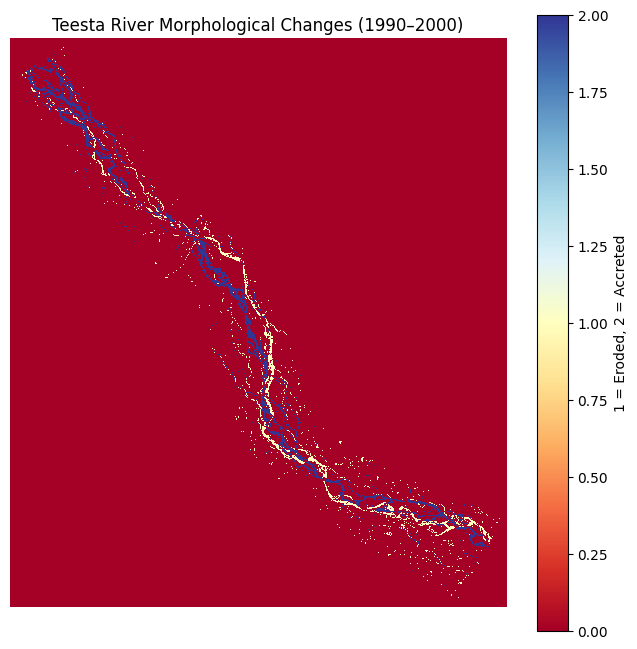

In [29]:
plt.figure(figsize=(8, 8))
plt.imshow(change_map, cmap='RdYlBu', interpolation='none')
plt.title('Teesta River Morphological Changes (1990–2000)')
plt.colorbar(label='1 = Eroded, 2 = Accreted')
plt.axis('off')
plt.show()

In [30]:
# Update raster profile for binary output
output_profile = profile.copy()
output_profile.update(dtype=rasterio.uint8, count=1, compress='lzw')

In [31]:
# Save eroded raster (1 for eroded, 0 elsewhere)
with rasterio.open("eroded_area.tif", "w", **output_profile) as dst:
    dst.write(eroded.astype(rasterio.uint8), 1)

In [32]:
with rasterio.open("accreted_area.tif", "w", **output_profile) as dst:
    dst.write(accreted.astype(rasterio.uint8), 1)

In [33]:
# 1=eroded 2=accreted
with rasterio.open("change_map.tif", "w", **output_profile) as dst:
    dst.write(change_map.astype(rasterio.uint8), 1)
